# Entropy-regularized Optimal Transport

## Reference

This refers to the following paper by Marco Cuturi:
> Cuturi, M. (2013). 
> Sinkhorn distances: Lightspeed computation of optimal transport. 
> In Advances in Neural Information Processing Systems (pp. 2292-2300).

## Problem statement

Given two empirical probability measures $\mu = \sum_i a_i \delta_{x_i}$ and $\nu = \sum_j b_j \delta_{y_j}$, and a distance matrix $M = \left[d(x_i, y_j)^p\right]_{i,j}$, entropy-regularized optimal transport aims at minimizing (over $P$) the following quantity:
$$C(P) = \left\langle P, M\right\rangle - \gamma H(P)$$
where $P$ is such that its rows sum to $\mathbf{a}$ and its columns sum to $\mathbf{b}$.

The minimum cost $C(P^*)$ is the Regularized Wassertein (not a distance anymore).
## The case of histograms (weighted diracs in 1d)

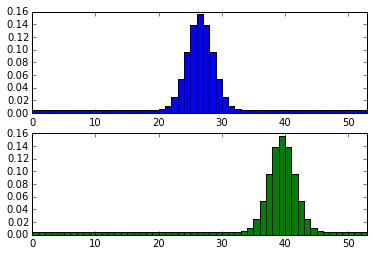

In [13]:
%matplotlib inline
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy
from scipy.signal import gaussian
from scipy.spatial.distance import cdist, pdist
from scipy.stats import entropy, multivariate_normal

n = 53
h1 = gaussian(n, std=2.)
h2 = gaussian(int(1.5 * n), std=2.)[:n]
x = numpy.arange(n)
h1 += .03
h2 += .03
h1 /= numpy.sum(h1)
h2 /= numpy.sum(h2)
h1 = h1.reshape((-1, 1))
h2 = h2.reshape((-1, 1))

pylab.subplot(2, 1, 1)
_ = pylab.bar(x, h1, width=1., color="b")
_ = pylab.xlim(0, n)
pylab.subplot(2, 1, 2)
_ = pylab.bar(x, h2, width=1., color="g")
_ = pylab.xlim(0, n)

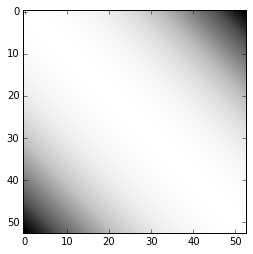

In [2]:
m = cdist(numpy.linspace(0, 1, n).reshape((-1, 1)), numpy.linspace(0, 1, n).reshape((-1, 1)), "sqeuclidean")
_ = pylab.imshow(m, cmap=pylab.cm.Greys)

Then, it is time to define a Sinkhorn iteration:

In [3]:
def one_iter(a, b, p, q, xi):
    a_out = p / numpy.dot(xi, b)
    b_out = q / numpy.dot(xi.T, a)
    return a_out, b_out

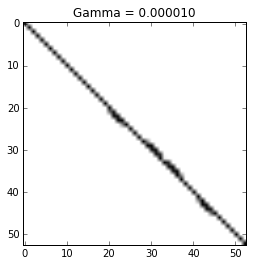

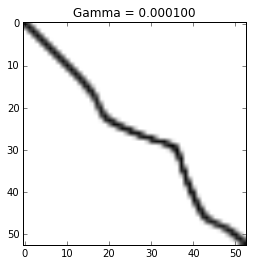

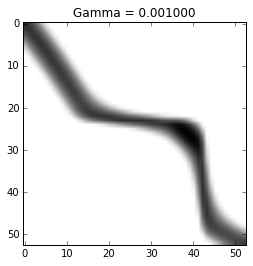

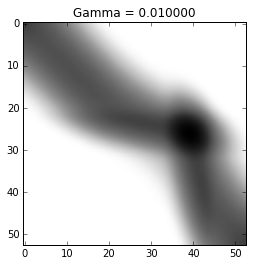

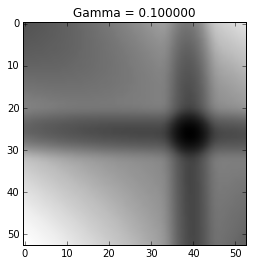

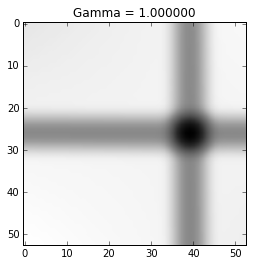

In [4]:
for gamma in [.00001, .0001, .001, .01, .1, 1.]:
    a = numpy.ones((n, 1))
    b = numpy.ones((n, 1))
    pylab.figure()
    xi = numpy.exp(-m / gamma)
    for _ in range(100):
        a, b = one_iter(a, b, h1, h2, xi)
    pi = numpy.dot(numpy.dot(numpy.diagflat(a), xi), numpy.diagflat(b))
    _ = pylab.imshow(numpy.log(pi + 1e-6), cmap=pylab.cm.Greys)
    _ = pylab.title("Gamma = %f" % gamma)

## The case of empirical distributions with uniform weights (unweighted sets)

Here, we have two sets of points (green ones and blue ones) in 2d and want to assess similarity between the sets.

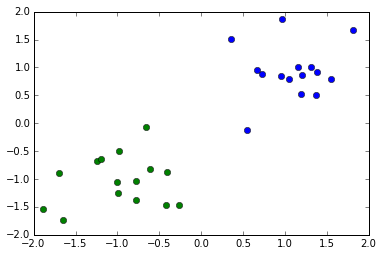

In [5]:
n = 15
set1 = numpy.random.randn(n, 2) * .5 + 1.
set2 = numpy.random.randn(n, 2) * .5 - 1.

p1 = numpy.ones((n, 1)) / n
p2 = numpy.ones((n, 1)) / n

_ = pylab.plot(set1[:, 0], set1[:, 1], "bo")
_ = pylab.plot(set2[:, 0], set2[:, 1], "go")

Entropy-regularized Wasserstein is -0.433160


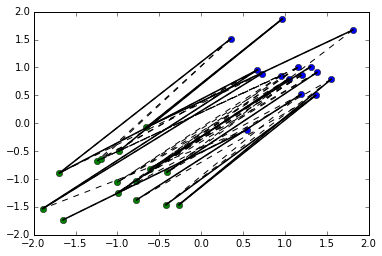

In [6]:
m = cdist(set1, set2, "sqeuclidean")
gamma = .1
xi = numpy.exp(-m / gamma)

a = numpy.ones((n, 1))
b = numpy.ones((n, 1))
for _ in range(100):
    a, b = one_iter(a, b, p1, p2, xi)
pi = numpy.dot(numpy.dot(numpy.diagflat(a), xi), numpy.diagflat(b))

indices_match = numpy.argmax(pi, axis=1)

_ = pylab.plot(set1[:, 0], set1[:, 1], "bo")
_ = pylab.plot(set2[:, 0], set2[:, 1], "go")

# First, strong matches
idxi, idxj = numpy.nonzero(pi > numpy.percentile(pi, 100 * (n - 1) / n))
for i, j in zip(idxi, idxj):
    _ = pylab.plot([set1[i, 0], set2[j, 0]], [set1[i, 1], set2[j, 1]], "k-", linewidth=1.5)

# Then, weak ones
idxi, idxj = numpy.nonzero(pi > numpy.percentile(pi, 100 * (n - 3) / n))
for i, j in zip(idxi, idxj):
    _ = pylab.plot([set1[i, 0], set2[j, 0]], [set1[i, 1], set2[j, 1]], "k--", linewidth=1)

dst = numpy.sum(pi * m) - gamma * entropy(pi.reshape(-1, ))
print("Entropy-regularized Wasserstein is %f" % dst)

## Computing Wasserstein barycenters

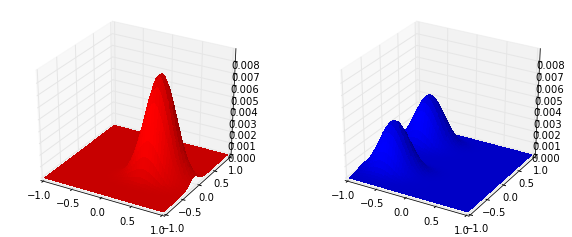

In [15]:
n = 50
arr_x, arr_y = numpy.linspace(-1, 1, n), numpy.linspace(-1, 1, n)
x, y = numpy.meshgrid(arr_x, arr_y)
pos = numpy.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv1 = multivariate_normal([0.5, -0.2], [[.05, 0.01], [0.01, 0.02]])
pdf1 = rv1.pdf(pos)

rv2 = multivariate_normal([-0.5, 0.5], [[.05, 0.01], [0.01, 0.02]])
pdf2 = rv2.pdf(pos)
rv3 = multivariate_normal([-0.5, -0.5], [[.05, 0.01], [0.01, 0.02]])
pdf2 += rv3.pdf(pos)

pdf1 /= numpy.sum(pdf1)
pdf2 /= numpy.sum(pdf2)

pylab.figure(figsize=(10, 4))
ax = pylab.subplot(1, 2, 1, projection="3d")
surf1 = ax.plot_surface(x, y, pdf1, rstride=1, cstride=1, color="r", linewidth=0,
                        antialiased=False)
ax.set_zlim3d([0, numpy.max(pdf1)])
ax = pylab.subplot(1, 2, 2, projection="3d")
surf2 = ax.plot_surface(x, y, pdf2, rstride=1, cstride=1, color="b", linewidth=0,
                        antialiased=False)
_ = ax.set_zlim3d([0, numpy.max(pdf1)])

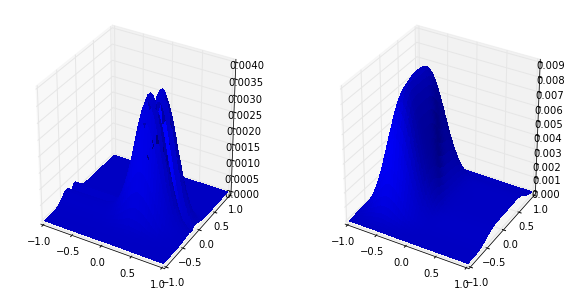

In [67]:
m = cdist(pos.reshape((-1, 2)), pos.reshape((-1, 2)), "sqeuclidean")
gamma = .005
xi = numpy.exp(-m / gamma)

a = numpy.ones((n * n, 1))
b = numpy.ones((n * n, 1))
for _ in range(100):
    a, b = one_iter(a, b, pdf1.reshape((-1, 1)), pdf2.reshape((-1, 1)), xi)
pi = numpy.dot(numpy.dot(numpy.diagflat(a), xi), numpy.diagflat(b))

pylab.figure(figsize=(10, 5))
ax = pylab.subplot(1, 2, 1, projection="3d")
surf = ax.plot_surface(x, y, 
                       numpy.dot(pi / numpy.sum(pi, axis=1).reshape((-1, 1)), pdf2.reshape((-1, 1))).reshape((n, n)), 
                       rstride=1, cstride=1, linewidth=0, antialiased=False)
ax = pylab.subplot(1, 2, 2, projection="3d")
surf = ax.plot_surface(x, y, 
                       numpy.dot(pdf1.reshape((1, -1)), pi / numpy.sum(pi, axis=0).reshape((1, -1))).reshape((n, n)), 
                       rstride=1, cstride=1, linewidth=0, antialiased=False)

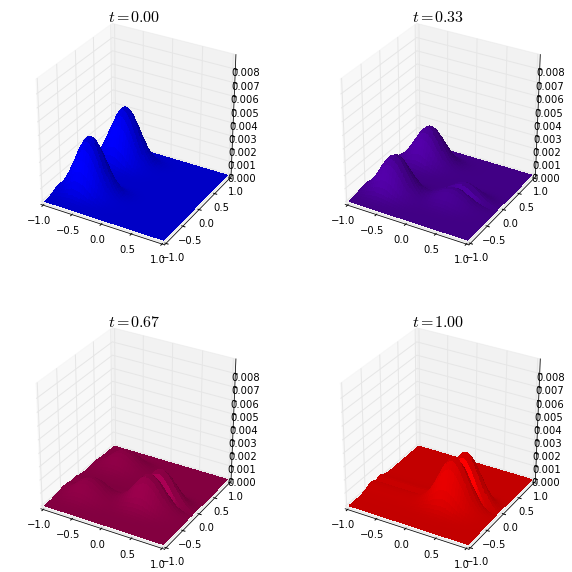

In [50]:
tr = numpy.dot(pi / numpy.sum(pi, axis=1).reshape((-1, 1)), pdf2.reshape((-1, 1)))

pylab.figure(figsize=(10, 10))
for idx, t in enumerate([0., 0.33, 0.67, 1.]):
    tr_pdf1 = (1 - t) * pdf2 + t * tr.reshape((n, n))
    ax = pylab.subplot(2, 2, idx + 1, projection="3d")
    surf2 = ax.plot_surface(x, y, tr_pdf1, rstride=1, cstride=1, color=(t, 0., 1. - t), linewidth=0,
                            antialiased=False)
    _ = pylab.title("$t = %.2f$" % t, fontsize=16)
    _ = ax.set_zlim3d([0, numpy.max(pdf1)])